In [1]:
import sys
sys.path.append('../..')
from matplotlib import pyplot as plt
import numpy as np
import torch
import yaml
from omegaconf import OmegaConf
import math
import core.nn as nn

# Load the configuration
file_path = "config.yaml"
with open(file_path, 'r') as file:
    config = OmegaConf.create(yaml.safe_load(file))

# Set the seed
torch.manual_seed(config.seed)
np.random.seed(config.seed)

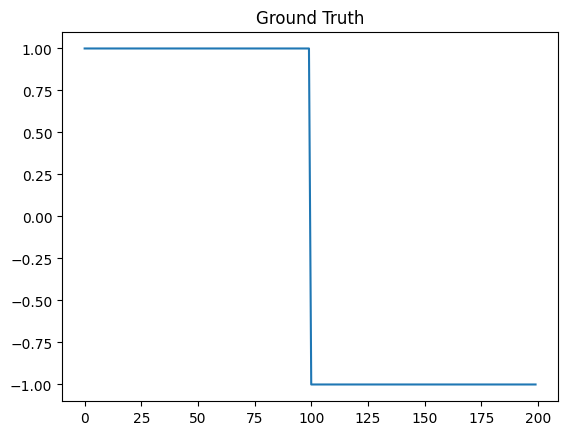

In [2]:
def example_function(config):
    x = np.linspace(config.min, config.max, config.samples)
    function = {
        "Gaussian": _gaussian,
        "Constant": _constant,
    }[config.function]
    return function(config, x)

def _gaussian(config, x):
    mean = config.gauss_mean
    sigma = config.gauss_sigma
    # apply function
    f = (
        1
        / (sigma * math.sqrt(2.0 * math.pi))
        * np.exp(-1 / 2.0 * ((x - mean) / sigma) ** 2)
    )
    f = 1 / float(max(f)) * f
    # return
    return f


def _constant(config, x):
    # apply function
    f = np.ones_like(x)
    f[int(len(f) / 2) :] = -1.0
    # return
    return f

function = example_function(config)
plt.plot(function)
plt.title("Ground Truth")
plt.show()

In [3]:
model = nn.KernelNet(
    out_channels=1,
    hidden_channels=config.hidden_channels,
    bias=True,
    omega_0=config.omega_0
)

In [4]:
in_channels = 1
out_channels = 10
hidden_channels = 32
bias = True
omega_0 = 30.0

ckconv = nn.CKConv(in_channels, out_channels, hidden_channels, bias, omega_0)

The size of the Input is: torch.Size([1, 1, 100])
The size of the Convolutional Kernel is: torch.Size([10, 1, 100])
The size of the Output is: torch.Size([1, 10, 1])
The number of parameters of the conv. layer is: 1534


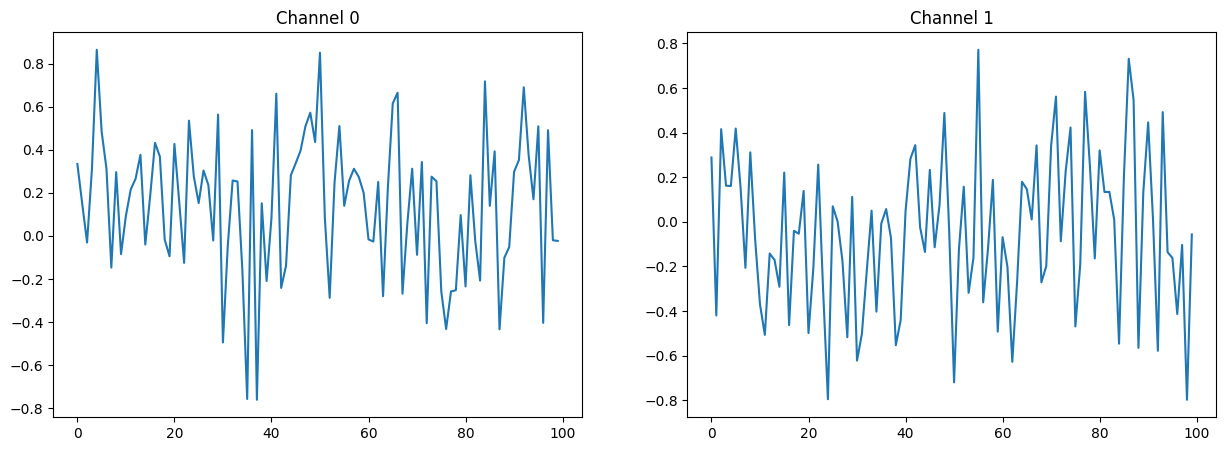

In [8]:
# ------------------------------
# Parameter counter
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# -----------------------------

# Input:
length = 100
input_channels = 1
batch_size = 1

input = torch.rand([batch_size, input_channels, length])
output = ckconv(input) #inference with just one layer

print(f'The size of the Input is: {input.shape}')
print(f'The size of the Convolutional Kernel is: {ckconv.conv_kernel.shape}')
print(f'The size of the Output is: {output.shape}')
print(f'The number of parameters of the conv. layer is: {num_params(ckconv)}')
fig, axs = plt.subplots(1, 2,figsize=(15,5))
for i in range(2):
    axs[i].set_title('Channel {}'.format(i))
    axs[i].plot(ckconv.conv_kernel.view(out_channels, length)[i].detach().numpy())
plt.show()

In [6]:
# input to the model
x = ( torch
     .linspace(config.min, config.max, config.samples)
     .type(torch.FloatTensor)
     .unsqueeze(0)
     .unsqueeze(0)
)

# actual output of the target function
f = ( torch
     .from_numpy(function)
     .type(torch.FloatTensor)
     .unsqueeze(0)
     .unsqueeze(0) 
)